In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import math
from pylab import rcParams

# 그래프 사이즈 지정
rcParams['figure.figsize'] = 15,10

In [2]:
df = pd.read_csv('./final.csv')
df['Date'] = pd.to_datetime(df['Date'])  # datetime으로 변환
df1 = df.set_index('Date')  # Date를 인덱스로 지정
df_y = pd.DataFrame(df1['Close'].resample('3BMS').first())  # y: 분기의 첫날(BMS)의 종가로 지정
df1 = df1.reset_index()  # 다시 컬럼으로 변환
df_y = df_y.reset_index()
df_y = df_y.iloc[1:, :]  # 11년 1월을 예측할 데이터가 존재하지 않기 때문에 제외

## LSTM 준비용 코드

In [3]:
import tensorflow as tf

In [4]:
df1 = df1.reset_index()

In [5]:
x_list = []

In [6]:
for i in range(2011, 2023):
    for j in range(1, 13):
        if j < 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (
                        df1['Date'] < (str(i) + '-' + str(0) + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)
        elif j == 9:
            cond = (df1['Date'] >= (str(i) + '-' + str(0) + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)
        elif j == 12:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i + 1) + '-' + str(0) + str(1)))
            x_list.append(df1.loc[cond]['Close'].values)
        else:
            cond = (df1['Date'] >= (str(i) + '-' + str(j))) & (df1['Date'] < (str(i) + '-' + str(j + 1)))
            x_list.append(df1.loc[cond]['Close'].values)

In [7]:
x_list

[array([273.81, 275.78, 275.35, 274.72, 275.61, 273.99, 275.1 , 276.17,
        275.52, 278.17, 277.05, 276.6 , 279.25, 277.75, 272.67, 274.5 ,
        275.18, 278.81, 279.2 , 278.45, 273.12]),
 array([273.45, 274.9 , 273.16, 269.9 , 264.57, 260.4 , 266.02, 265.4 ,
        262.56, 261.23, 265.8 , 264.55, 260.13, 259.21, 257.69, 259.28,
        256.36]),
 array([254.96, 260.48, 265.42, 261.44, 263.33, 263.8 , 260.59, 256.83,
        260.69, 254.29, 259.44, 259.8 , 262.39, 264.89, 266.05, 265.67,
        268.93, 271.66, 272.13, 274.22, 277.04, 278.87]),
 array([280.73, 280.01, 282.03, 281.35, 280.45, 281.05, 280.49, 276.13,
        280.68, 283.15, 282.8 , 282.14, 280.43, 287.19, 291.16, 290.84,
        292.69, 291.38, 292.08, 292.15, 290.39]),
 array([295.35, 291.65, 288.46, 283.68, 282.59, 286.3 , 280.02, 279.59,
        277.22, 277.15, 281.76, 276.47, 278.59, 271.19, 271.78, 268.62,
        276.33, 277.35, 276.32, 282.76]),
 array([282.75, 278.76, 278.84, 276.97, 274.46, 272.44, 269.04

In [8]:
len(x_list)

144

x_list를 만드는 방법은 다음과 같다.
- 데이터를 3개월치씩 묶은 후 최소 개장 일수를 찾는다. = x_list_fin
- 최소 개장 일수 기준으로 짜른다. = x_list_fin_fin

In [9]:
x_list_fin = []

In [10]:
for i in range(len(x_list)):
    if i % 3 == 0:
        x_list_fin.append(np.concatenate((x_list[i], x_list[i+1], x_list[i+2])))
    else :
        continue

In [11]:
x_list_fin_fin = []

In [12]:
for i in range(len(x_list_fin)):
    x_list_fin_fin.append(x_list_fin[i][-57:])

In [13]:
x_list_fin_fin

[array([274.72, 275.61, 273.99, 275.1 , 276.17, 275.52, 278.17, 277.05,
        276.6 , 279.25, 277.75, 272.67, 274.5 , 275.18, 278.81, 279.2 ,
        278.45, 273.12, 273.45, 274.9 , 273.16, 269.9 , 264.57, 260.4 ,
        266.02, 265.4 , 262.56, 261.23, 265.8 , 264.55, 260.13, 259.21,
        257.69, 259.28, 256.36, 254.96, 260.48, 265.42, 261.44, 263.33,
        263.8 , 260.59, 256.83, 260.69, 254.29, 259.44, 259.8 , 262.39,
        264.89, 266.05, 265.67, 268.93, 271.66, 272.13, 274.22, 277.04,
        278.87]),
 array([281.05, 280.49, 276.13, 280.68, 283.15, 282.8 , 282.14, 280.43,
        287.19, 291.16, 290.84, 292.69, 291.38, 292.08, 292.15, 290.39,
        295.35, 291.65, 288.46, 283.68, 282.59, 286.3 , 280.02, 279.59,
        277.22, 277.15, 281.76, 276.47, 278.59, 271.19, 271.78, 268.62,
        276.33, 277.35, 276.32, 282.76, 282.75, 278.76, 278.84, 276.97,
        274.46, 272.44, 269.04, 269.79, 273.67, 274.53, 268.88, 266.22,
        264.39, 268.65, 270.71, 269.34, 274.31

In [14]:
X = np.array(x_list_fin_fin)

In [15]:
y_list = []

In [16]:
for i in range(len(df_y['Close'].tolist())):
    y_list.append(np.array([df_y['Close'].tolist()[i]]))

In [17]:
y = np.array(y_list)

## LSTM

In [18]:
from sklearn.model_selection import train_test_split
from keras import models, layers, callbacks, optimizers

In [19]:
X1 = X[:-1]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state = 42)

In [21]:
x = layers.Input(shape=(X_train.shape[1], 1))
lstm = layers.LSTM(32, return_sequences = False)(x)
#Dropout = layers.Dropout(0.3)(lstm)
dense = layers.Dense(16)(lstm)
norm = layers.BatchNormalization()(dense)
relu = layers.ReLU()(norm)
#dense = layers.Dense(8)(relu)
#norm = layers.BatchNormalization()(dense)
#relu = layers.ReLU()(norm)
y = layers.Dense(1)(relu)
model = models.Model(x, y)
optimizer = optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer, 'mean_squared_error')  # loss function: mean_squared_error 사용

In [22]:
# EarlyStopping: val_loss가 제일 낮아도 Epoch 100번은 더 해봐라
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=150)

In [23]:
# 모델 학습
history = model.fit(X_train, y_train, epochs = 2000, validation_data = [X_test, y_test], 
                    batch_size = 16, verbose = 1)

Epoch 1/2000
3/3 [==============================] - 4s 450ms/step - loss: 82876.4141 - val_loss: 89668.8438
Epoch 2/2000
3/3 [==============================] - 0s 43ms/step - loss: 82793.0547 - val_loss: 89666.1875
Epoch 3/2000
3/3 [==============================] - 0s 38ms/step - loss: 82745.7188 - val_loss: 89659.1016
Epoch 4/2000
3/3 [==============================] - 0s 41ms/step - loss: 82718.2969 - val_loss: 89650.3359
Epoch 5/2000
3/3 [==============================] - 0s 44ms/step - loss: 82706.7109 - val_loss: 89642.2500
Epoch 6/2000
3/3 [==============================] - 0s 40ms/step - loss: 82697.8594 - val_loss: 89635.7812
Epoch 7/2000
3/3 [==============================] - 0s 39ms/step - loss: 82690.6250 - val_loss: 89630.5625
Epoch 8/2000
3/3 [==============================] - 0s 49ms/step - loss: 82684.3359 - val_loss: 89624.6562
Epoch 9/2000
3/3 [==============================] - 0s 44ms/step - loss: 82678.7656 - val_loss: 89618.4609
Epoch 10/2000
3/3 [=================

Epoch 77/2000
3/3 [==============================] - 0s 65ms/step - loss: 81098.9297 - val_loss: 88370.5234
Epoch 78/2000
3/3 [==============================] - 0s 40ms/step - loss: 81059.8750 - val_loss: 88246.8359
Epoch 79/2000
3/3 [==============================] - 0s 42ms/step - loss: 81056.6016 - val_loss: 88085.5859
Epoch 80/2000
3/3 [==============================] - 0s 49ms/step - loss: 81006.5703 - val_loss: 88015.7422
Epoch 81/2000
3/3 [==============================] - 0s 48ms/step - loss: 80998.7656 - val_loss: 88058.0938
Epoch 82/2000
3/3 [==============================] - 0s 54ms/step - loss: 80967.9688 - val_loss: 88134.4688
Epoch 83/2000
3/3 [==============================] - 0s 51ms/step - loss: 81017.8672 - val_loss: 88034.7109
Epoch 84/2000
3/3 [==============================] - 0s 45ms/step - loss: 80932.2891 - val_loss: 87948.7812
Epoch 85/2000
3/3 [==============================] - 0s 42ms/step - loss: 80869.7109 - val_loss: 87893.7812
Epoch 86/2000
3/3 [=========

3/3 [==============================] - 0s 49ms/step - loss: 74229.1641 - val_loss: 75526.7422
Epoch 228/2000
3/3 [==============================] - 0s 42ms/step - loss: 74368.5391 - val_loss: 75671.9609
Epoch 229/2000
3/3 [==============================] - 0s 42ms/step - loss: 74124.1172 - val_loss: 75279.2422
Epoch 230/2000
3/3 [==============================] - 0s 48ms/step - loss: 74026.0781 - val_loss: 75557.2656
Epoch 231/2000
3/3 [==============================] - 0s 49ms/step - loss: 73984.4141 - val_loss: 75647.9609
Epoch 232/2000
3/3 [==============================] - 0s 41ms/step - loss: 74185.3359 - val_loss: 76276.9453
Epoch 233/2000
3/3 [==============================] - 0s 40ms/step - loss: 73876.8984 - val_loss: 75118.1016
Epoch 234/2000
3/3 [==============================] - 0s 40ms/step - loss: 74088.7031 - val_loss: 74687.4062
Epoch 235/2000
3/3 [==============================] - 0s 39ms/step - loss: 73909.4609 - val_loss: 75456.1016
Epoch 236/2000
3/3 [==============

3/3 [==============================] - 0s 45ms/step - loss: 61696.8555 - val_loss: 67829.4297
Epoch 378/2000
3/3 [==============================] - 0s 39ms/step - loss: 62078.8984 - val_loss: 64172.3477
Epoch 379/2000
3/3 [==============================] - 0s 39ms/step - loss: 61546.3711 - val_loss: 60268.4805
Epoch 380/2000
3/3 [==============================] - 0s 41ms/step - loss: 61601.6055 - val_loss: 59665.4336
Epoch 381/2000
3/3 [==============================] - 0s 43ms/step - loss: 61442.3359 - val_loss: 62544.0352
Epoch 382/2000
3/3 [==============================] - 0s 39ms/step - loss: 61293.9727 - val_loss: 62745.7617
Epoch 383/2000
3/3 [==============================] - 0s 39ms/step - loss: 61354.3125 - val_loss: 62486.6445
Epoch 384/2000
3/3 [==============================] - 0s 44ms/step - loss: 61364.8008 - val_loss: 63557.0508
Epoch 385/2000
3/3 [==============================] - 0s 54ms/step - loss: 61117.1797 - val_loss: 63316.5938
Epoch 386/2000
3/3 [==============

3/3 [==============================] - 0s 40ms/step - loss: 47873.7227 - val_loss: 50498.3867
Epoch 528/2000
3/3 [==============================] - 0s 40ms/step - loss: 47798.2109 - val_loss: 49144.8320
Epoch 529/2000
3/3 [==============================] - 0s 41ms/step - loss: 47133.2422 - val_loss: 48481.6836
Epoch 530/2000
3/3 [==============================] - 0s 39ms/step - loss: 48202.9688 - val_loss: 48942.0039
Epoch 531/2000
3/3 [==============================] - 0s 40ms/step - loss: 48640.1719 - val_loss: 51332.5312
Epoch 532/2000
3/3 [==============================] - 0s 40ms/step - loss: 46931.8555 - val_loss: 48530.7070
Epoch 533/2000
3/3 [==============================] - 0s 40ms/step - loss: 47370.4219 - val_loss: 46338.7383
Epoch 534/2000
3/3 [==============================] - 0s 39ms/step - loss: 47281.4609 - val_loss: 46177.6562
Epoch 535/2000
3/3 [==============================] - 0s 43ms/step - loss: 46698.4492 - val_loss: 49325.4336
Epoch 536/2000
3/3 [==============

3/3 [==============================] - 0s 41ms/step - loss: 34337.3047 - val_loss: 30234.1250
Epoch 678/2000
3/3 [==============================] - 0s 48ms/step - loss: 33684.3789 - val_loss: 34189.8242
Epoch 679/2000
3/3 [==============================] - 0s 50ms/step - loss: 34741.9805 - val_loss: 32113.5918
Epoch 680/2000
3/3 [==============================] - 0s 50ms/step - loss: 34501.2617 - val_loss: 27500.4609
Epoch 681/2000
3/3 [==============================] - 0s 41ms/step - loss: 33862.4727 - val_loss: 25734.2812
Epoch 682/2000
3/3 [==============================] - 0s 58ms/step - loss: 33386.1445 - val_loss: 27188.3223
Epoch 683/2000
3/3 [==============================] - 0s 51ms/step - loss: 33228.3555 - val_loss: 29062.8105
Epoch 684/2000
3/3 [==============================] - 0s 47ms/step - loss: 33011.2422 - val_loss: 31490.8340
Epoch 685/2000
3/3 [==============================] - 0s 52ms/step - loss: 33725.4141 - val_loss: 32873.1445
Epoch 686/2000
3/3 [==============

3/3 [==============================] - 0s 41ms/step - loss: 23239.6992 - val_loss: 22482.2949
Epoch 828/2000
3/3 [==============================] - 0s 43ms/step - loss: 21778.3770 - val_loss: 19300.6191
Epoch 829/2000
3/3 [==============================] - 0s 38ms/step - loss: 22808.8848 - val_loss: 19064.9375
Epoch 830/2000
3/3 [==============================] - 0s 41ms/step - loss: 22040.5801 - val_loss: 19395.8828
Epoch 831/2000
3/3 [==============================] - 0s 42ms/step - loss: 21716.8984 - val_loss: 21388.5332
Epoch 832/2000
3/3 [==============================] - 0s 41ms/step - loss: 21281.3555 - val_loss: 22943.1191
Epoch 833/2000
3/3 [==============================] - 0s 43ms/step - loss: 21142.2539 - val_loss: 19982.6016
Epoch 834/2000
3/3 [==============================] - 0s 44ms/step - loss: 20951.2246 - val_loss: 19970.0488
Epoch 835/2000
3/3 [==============================] - 0s 41ms/step - loss: 21234.8750 - val_loss: 20358.6855
Epoch 836/2000
3/3 [==============

3/3 [==============================] - 0s 47ms/step - loss: 13987.7852 - val_loss: 6481.0405
Epoch 978/2000
3/3 [==============================] - 0s 53ms/step - loss: 15488.2676 - val_loss: 6325.0234
Epoch 979/2000
3/3 [==============================] - 0s 49ms/step - loss: 14552.9492 - val_loss: 6967.3555
Epoch 980/2000
3/3 [==============================] - 0s 52ms/step - loss: 14489.8496 - val_loss: 9917.0225
Epoch 981/2000
3/3 [==============================] - 0s 42ms/step - loss: 15466.8965 - val_loss: 13188.8135
Epoch 982/2000
3/3 [==============================] - 0s 44ms/step - loss: 13647.5713 - val_loss: 15168.6768
Epoch 983/2000
3/3 [==============================] - 0s 43ms/step - loss: 14629.4443 - val_loss: 15902.8516
Epoch 984/2000
3/3 [==============================] - 0s 47ms/step - loss: 14567.4473 - val_loss: 14285.6562
Epoch 985/2000
3/3 [==============================] - 0s 41ms/step - loss: 12819.0156 - val_loss: 12189.8857
Epoch 986/2000
3/3 [==================

Epoch 1128/2000
3/3 [==============================] - 0s 47ms/step - loss: 7066.7017 - val_loss: 3410.9844
Epoch 1129/2000
3/3 [==============================] - 0s 41ms/step - loss: 6312.2480 - val_loss: 3358.0547
Epoch 1130/2000
3/3 [==============================] - 0s 50ms/step - loss: 6378.8247 - val_loss: 4122.7612
Epoch 1131/2000
3/3 [==============================] - 0s 49ms/step - loss: 6602.0127 - val_loss: 6420.8672
Epoch 1132/2000
3/3 [==============================] - 0s 42ms/step - loss: 6586.1650 - val_loss: 7229.2593
Epoch 1133/2000
3/3 [==============================] - 0s 49ms/step - loss: 6609.9883 - val_loss: 7606.7964
Epoch 1134/2000
3/3 [==============================] - 0s 52ms/step - loss: 6317.6211 - val_loss: 7431.8555
Epoch 1135/2000
3/3 [==============================] - 0s 53ms/step - loss: 5782.4756 - val_loss: 7387.3765
Epoch 1136/2000
3/3 [==============================] - 0s 47ms/step - loss: 7624.8555 - val_loss: 6940.5522
Epoch 1137/2000
3/3 [=======

Epoch 1204/2000
3/3 [==============================] - 0s 46ms/step - loss: 5366.4194 - val_loss: 2031.7139
Epoch 1205/2000
3/3 [==============================] - 0s 47ms/step - loss: 5005.8706 - val_loss: 1913.3359
Epoch 1206/2000
3/3 [==============================] - 0s 40ms/step - loss: 4141.8677 - val_loss: 1820.2706
Epoch 1207/2000
3/3 [==============================] - 0s 41ms/step - loss: 4038.8379 - val_loss: 1791.7979
Epoch 1208/2000
3/3 [==============================] - 0s 53ms/step - loss: 4058.3679 - val_loss: 2046.7457
Epoch 1209/2000
3/3 [==============================] - 0s 40ms/step - loss: 4256.6226 - val_loss: 2615.6794
Epoch 1210/2000
3/3 [==============================] - 0s 40ms/step - loss: 4038.2969 - val_loss: 3157.0178
Epoch 1211/2000
3/3 [==============================] - 0s 40ms/step - loss: 4239.6650 - val_loss: 3392.0105
Epoch 1212/2000
3/3 [==============================] - 0s 41ms/step - loss: 4349.9453 - val_loss: 3565.4795
Epoch 1213/2000
3/3 [=======

Epoch 1280/2000
3/3 [==============================] - 0s 52ms/step - loss: 2461.1106 - val_loss: 1907.3301
Epoch 1281/2000
3/3 [==============================] - 0s 40ms/step - loss: 2696.7959 - val_loss: 1946.4048
Epoch 1282/2000
3/3 [==============================] - 0s 40ms/step - loss: 3090.0488 - val_loss: 1906.8770
Epoch 1283/2000
3/3 [==============================] - 0s 40ms/step - loss: 2234.5605 - val_loss: 1871.6768
Epoch 1284/2000
3/3 [==============================] - 0s 48ms/step - loss: 2606.6714 - val_loss: 1886.0331
Epoch 1285/2000
3/3 [==============================] - 0s 45ms/step - loss: 2623.0664 - val_loss: 1879.1747
Epoch 1286/2000
3/3 [==============================] - 0s 41ms/step - loss: 2183.1750 - val_loss: 1727.2637
Epoch 1287/2000
3/3 [==============================] - 0s 40ms/step - loss: 3593.0408 - val_loss: 1640.1636
Epoch 1288/2000
3/3 [==============================] - 0s 40ms/step - loss: 2733.0986 - val_loss: 1632.2174
Epoch 1289/2000
3/3 [=======

3/3 [==============================] - 0s 40ms/step - loss: 2572.1152 - val_loss: 542.1025
Epoch 1357/2000
3/3 [==============================] - 0s 38ms/step - loss: 1975.9919 - val_loss: 708.2585
Epoch 1358/2000
3/3 [==============================] - 0s 41ms/step - loss: 1578.8922 - val_loss: 367.7741
Epoch 1359/2000
3/3 [==============================] - 0s 39ms/step - loss: 1613.4099 - val_loss: 330.3429
Epoch 1360/2000
3/3 [==============================] - 0s 45ms/step - loss: 2116.7495 - val_loss: 394.5712
Epoch 1361/2000
3/3 [==============================] - 0s 60ms/step - loss: 1593.5997 - val_loss: 504.3962
Epoch 1362/2000
3/3 [==============================] - 0s 46ms/step - loss: 2242.1885 - val_loss: 639.4931
Epoch 1363/2000
3/3 [==============================] - 0s 69ms/step - loss: 1972.2069 - val_loss: 592.8610
Epoch 1364/2000
3/3 [==============================] - 0s 61ms/step - loss: 1799.2845 - val_loss: 707.5838
Epoch 1365/2000
3/3 [==============================] 

Epoch 1509/2000
3/3 [==============================] - 0s 42ms/step - loss: 1055.6638 - val_loss: 337.0919
Epoch 1510/2000
3/3 [==============================] - 0s 49ms/step - loss: 1006.3610 - val_loss: 251.7480
Epoch 1511/2000
3/3 [==============================] - 0s 51ms/step - loss: 1184.3000 - val_loss: 298.5739
Epoch 1512/2000
3/3 [==============================] - 0s 55ms/step - loss: 1057.3363 - val_loss: 361.0049
Epoch 1513/2000
3/3 [==============================] - 0s 54ms/step - loss: 1361.8834 - val_loss: 688.0773
Epoch 1514/2000
3/3 [==============================] - 0s 41ms/step - loss: 779.4305 - val_loss: 1610.9116
Epoch 1515/2000
3/3 [==============================] - 0s 39ms/step - loss: 771.1975 - val_loss: 2006.4547
Epoch 1516/2000
3/3 [==============================] - 0s 38ms/step - loss: 858.3779 - val_loss: 1755.2960
Epoch 1517/2000
3/3 [==============================] - 0s 40ms/step - loss: 500.0160 - val_loss: 1058.1874
Epoch 1518/2000
3/3 [================

Epoch 1586/2000
3/3 [==============================] - 0s 41ms/step - loss: 1200.5430 - val_loss: 820.1484
Epoch 1587/2000
3/3 [==============================] - 0s 39ms/step - loss: 867.8742 - val_loss: 1794.0013
Epoch 1588/2000
3/3 [==============================] - 0s 39ms/step - loss: 621.4153 - val_loss: 1375.2003
Epoch 1589/2000
3/3 [==============================] - 0s 39ms/step - loss: 645.4059 - val_loss: 1064.6237
Epoch 1590/2000
3/3 [==============================] - 0s 38ms/step - loss: 605.5577 - val_loss: 839.1401
Epoch 1591/2000
3/3 [==============================] - 0s 41ms/step - loss: 732.4146 - val_loss: 673.2049
Epoch 1592/2000
3/3 [==============================] - 0s 58ms/step - loss: 838.1734 - val_loss: 759.8438
Epoch 1593/2000
3/3 [==============================] - 0s 47ms/step - loss: 362.8249 - val_loss: 969.4637
Epoch 1594/2000
3/3 [==============================] - 0s 47ms/step - loss: 733.4536 - val_loss: 1026.2426
Epoch 1595/2000
3/3 [====================

Epoch 1663/2000
3/3 [==============================] - 0s 40ms/step - loss: 627.0540 - val_loss: 535.0599
Epoch 1664/2000
3/3 [==============================] - 0s 42ms/step - loss: 759.1036 - val_loss: 699.0685
Epoch 1665/2000
3/3 [==============================] - 0s 40ms/step - loss: 634.1632 - val_loss: 1042.2460
Epoch 1666/2000
3/3 [==============================] - 0s 39ms/step - loss: 647.0654 - val_loss: 932.8083
Epoch 1667/2000
3/3 [==============================] - 0s 45ms/step - loss: 475.9742 - val_loss: 697.4529
Epoch 1668/2000
3/3 [==============================] - 0s 42ms/step - loss: 528.7477 - val_loss: 574.7864
Epoch 1669/2000
3/3 [==============================] - 0s 40ms/step - loss: 474.5080 - val_loss: 492.8255
Epoch 1670/2000
3/3 [==============================] - 0s 42ms/step - loss: 497.6292 - val_loss: 712.4655
Epoch 1671/2000
3/3 [==============================] - 0s 48ms/step - loss: 293.5755 - val_loss: 1099.9630
Epoch 1672/2000
3/3 [=======================

Epoch 1740/2000
3/3 [==============================] - 0s 47ms/step - loss: 613.0394 - val_loss: 502.1847
Epoch 1741/2000
3/3 [==============================] - 0s 42ms/step - loss: 458.8991 - val_loss: 731.6905
Epoch 1742/2000
3/3 [==============================] - 0s 41ms/step - loss: 392.5365 - val_loss: 984.9478
Epoch 1743/2000
3/3 [==============================] - 0s 43ms/step - loss: 795.0676 - val_loss: 652.8704
Epoch 1744/2000
3/3 [==============================] - 0s 47ms/step - loss: 455.2413 - val_loss: 528.5164
Epoch 1745/2000
3/3 [==============================] - 0s 41ms/step - loss: 582.6071 - val_loss: 540.8914
Epoch 1746/2000
3/3 [==============================] - 0s 41ms/step - loss: 627.2306 - val_loss: 564.1878
Epoch 1747/2000
3/3 [==============================] - 0s 41ms/step - loss: 523.3291 - val_loss: 574.7183
Epoch 1748/2000
3/3 [==============================] - 0s 44ms/step - loss: 1368.1523 - val_loss: 490.9354
Epoch 1749/2000
3/3 [========================

Epoch 1817/2000
3/3 [==============================] - 0s 42ms/step - loss: 447.0966 - val_loss: 3927.2097
Epoch 1818/2000
3/3 [==============================] - 0s 41ms/step - loss: 574.8723 - val_loss: 3506.0447
Epoch 1819/2000
3/3 [==============================] - 0s 40ms/step - loss: 620.5228 - val_loss: 2995.9727
Epoch 1820/2000
3/3 [==============================] - 0s 45ms/step - loss: 670.5410 - val_loss: 2631.8174
Epoch 1821/2000
3/3 [==============================] - 0s 52ms/step - loss: 334.7271 - val_loss: 2470.3601
Epoch 1822/2000
3/3 [==============================] - 0s 54ms/step - loss: 327.9602 - val_loss: 2419.0969
Epoch 1823/2000
3/3 [==============================] - 0s 48ms/step - loss: 425.2899 - val_loss: 2487.8054
Epoch 1824/2000
3/3 [==============================] - 0s 40ms/step - loss: 356.8563 - val_loss: 2246.3767
Epoch 1825/2000
3/3 [==============================] - 0s 42ms/step - loss: 390.4374 - val_loss: 1970.1237
Epoch 1826/2000
3/3 [================

3/3 [==============================] - 0s 42ms/step - loss: 351.6616 - val_loss: 611.1744
Epoch 1895/2000
3/3 [==============================] - 0s 39ms/step - loss: 260.1529 - val_loss: 541.0114
Epoch 1896/2000
3/3 [==============================] - 0s 39ms/step - loss: 296.2455 - val_loss: 553.0772
Epoch 1897/2000
3/3 [==============================] - 0s 40ms/step - loss: 722.7375 - val_loss: 743.9593
Epoch 1898/2000
3/3 [==============================] - 0s 39ms/step - loss: 817.8046 - val_loss: 408.7606
Epoch 1899/2000
3/3 [==============================] - 0s 41ms/step - loss: 189.5144 - val_loss: 308.6708
Epoch 1900/2000
3/3 [==============================] - 0s 40ms/step - loss: 375.0815 - val_loss: 383.7188
Epoch 1901/2000
3/3 [==============================] - 0s 42ms/step - loss: 222.6362 - val_loss: 577.4639
Epoch 1902/2000
3/3 [==============================] - 0s 43ms/step - loss: 449.3921 - val_loss: 1113.4757
Epoch 1903/2000
3/3 [==============================] - 0s 39m

3/3 [==============================] - 0s 39ms/step - loss: 378.8518 - val_loss: 727.6985
Epoch 1972/2000
3/3 [==============================] - 0s 40ms/step - loss: 264.8328 - val_loss: 732.1919
Epoch 1973/2000
3/3 [==============================] - 0s 39ms/step - loss: 509.2632 - val_loss: 503.2953
Epoch 1974/2000
3/3 [==============================] - 0s 40ms/step - loss: 533.7144 - val_loss: 366.7214
Epoch 1975/2000
3/3 [==============================] - 0s 39ms/step - loss: 846.2952 - val_loss: 331.7371
Epoch 1976/2000
3/3 [==============================] - 0s 45ms/step - loss: 327.7834 - val_loss: 344.7383
Epoch 1977/2000
3/3 [==============================] - 0s 67ms/step - loss: 319.2418 - val_loss: 322.4280
Epoch 1978/2000
3/3 [==============================] - 0s 51ms/step - loss: 395.1427 - val_loss: 358.6635
Epoch 1979/2000
3/3 [==============================] - 0s 84ms/step - loss: 379.8542 - val_loss: 415.2336
Epoch 1980/2000
3/3 [==============================] - 0s 48ms

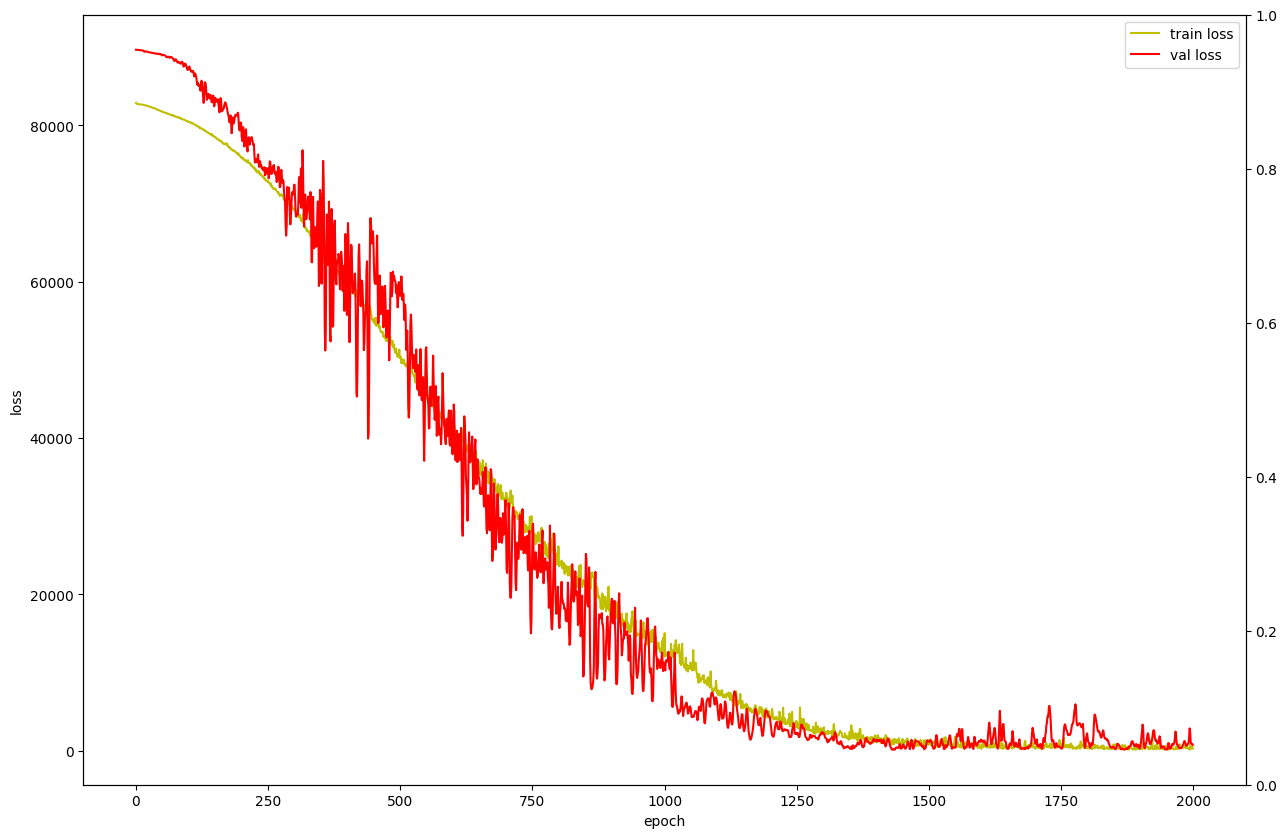

In [24]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.legend()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.show()

## 결정 계수

In [25]:
from sklearn.metrics import r2_score, mean_squared_error

In [26]:
# X 입력 -> 모델을 거쳐서 -> y 출력
y_train_predict = model.predict(X_train)

2/2 [==============================] - 1s 8ms/step


In [27]:
print(r2_score(y_train, y_train_predict))

0.7809803948025837


In [28]:
# mean_squared_error: 잔차의 제곱의 평균 = 잔차가 큰 데이터를 더 큰 패널티를 주는 것

# √mean_squared_error: 루트를 씌워주는 이유는 제곱을 지워주기 위해서
print(math.sqrt(mean_squared_error(y_train, y_train_predict)))  # sqrt: 루트

22.901770809796027


In [29]:
y_test_predict = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [30]:
print(r2_score(y_test, y_test_predict))

0.7608707121389262


In [31]:
# √mean_squared_error
print(math.sqrt(mean_squared_error(y_test, y_test_predict)))

27.468280693360477


## 예측

In [32]:
# 2022년 11월~ 2023년 1월 종가 데이터
test_list = pd.read_csv('./t_list.csv')  # test_list: 데이터프레임 형태

In [33]:
# Date 오름차순으로 정렬
test_list.sort_values(by = 'Date', ascending = True, inplace = True)

In [34]:
# 데이터 프레임 형태에서 시리즈를 뽑아서 넘파이 배열로 변환
test_array = np.array(test_list['Close'])

In [35]:
# 2023년 2월 1일의 종가 예측
print(model.predict(test_array.reshape(1, test_array.shape[0], 1)))

1/1 [==============================] - 1s 643ms/step
[[273.71448]]


실제값: 321.19

## 실제값과 예측값 시각화

In [36]:
# X1: 원본의 X 데이터가 들어가 있음
# LSTM에 들어갈 수 있도록 reshape하기
visual_predict = model.predict(X1.reshape(47, 57, 1))

2/2 [==============================] - 0s 10ms/step


In [37]:
# df_y: 예측할 데이터 프레임 = 매 월의 1일 데이터만 들어가 있음
df_date = df_y[['Date']].reset_index(drop = True)  # reset_index(drop = True): 순서 맞추기 위해 한거야 신경 쓰지마

In [38]:
# y_list: df_y를 리스트로 바꾼 것
visual_t = pd.DataFrame(y_list).reset_index(drop = True)

In [39]:
# concat: 두 개의 데이터 프레임 합치기 / axis = 1: 축 지정해서 Close-Date 형태로 만들어진다.
visual_t = pd.concat([visual_t, df_date], axis = 1)
visual_t.rename({0 : 'Close'}, axis = 'columns', inplace = True)  # inplace = True: 원본까지 바꾸기
visual_t
# 사실 df_y = visual_t 같은 것이당

,Close,Date
0,280.73,2011-04-01
1,278.77,2011-07-01
2,221.93,2011-10-03
3,238.70,2012-01-02
4,268.99,2012-04-02
5,244.46,2012-07-02
6,262.48,2012-10-01
7,269.16,2013-01-01
8,262.27,2013-04-01
9,241.05,2013-07-01


In [40]:
# visual_predict(원래 X값을 학습된 모델에 넣은 것)를 DataFrame으로 만들기
visual_y = pd.DataFrame(visual_predict).reset_index(drop = True)

In [41]:
visual_y = pd.concat([visual_y, df_date], axis = 1)
visual_y.rename({0 : 'Close'}, axis = 'columns', inplace = True)
visual_y

,Close,Date
0,261.625458,2011-04-01
1,259.647461,2011-07-01
2,232.533920,2011-10-03
3,213.814301,2012-01-02
4,251.560623,2012-04-02
5,216.530380,2012-07-02
6,245.395660,2012-10-01
7,247.603363,2013-01-01
8,247.424118,2013-04-01
9,214.448105,2013-07-01


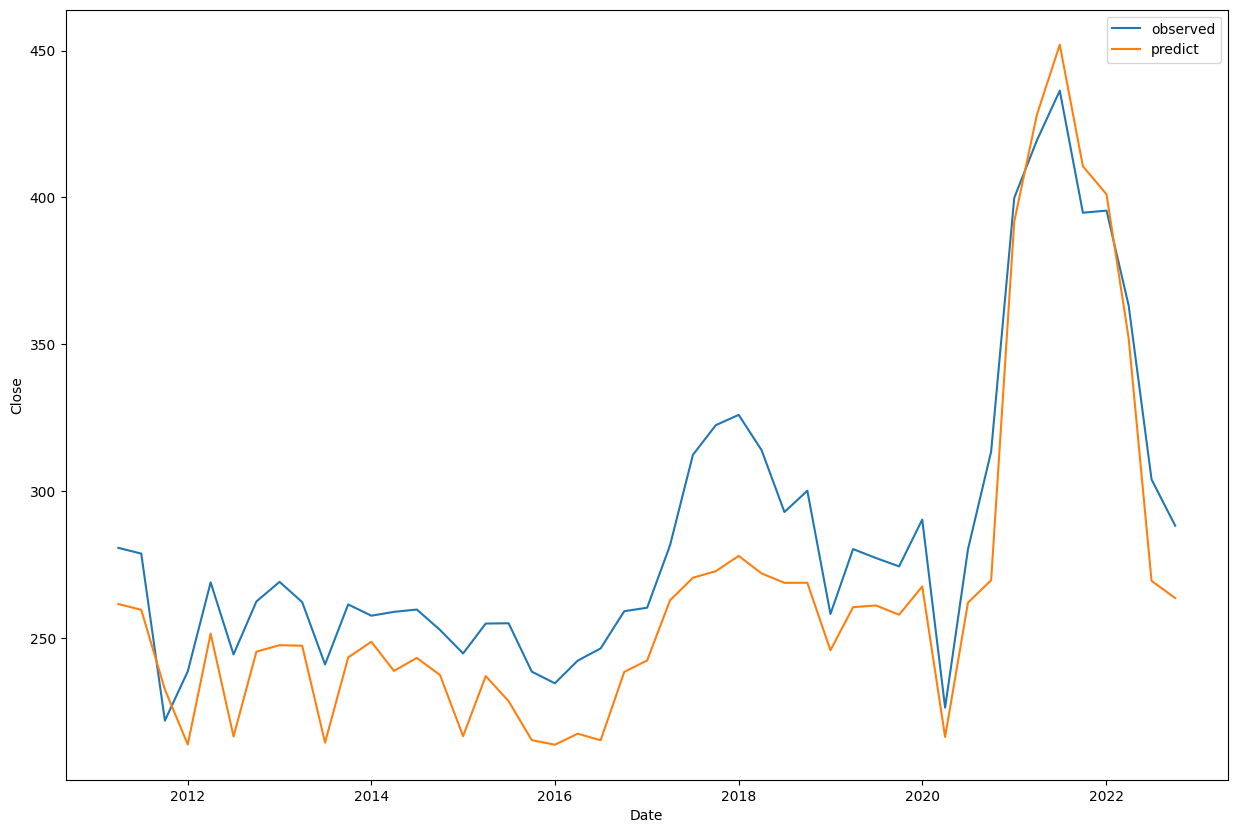

In [42]:
sns.lineplot(visual_t, x = 'Date', y = 'Close', label='observed')
sns.lineplot(visual_y, x = 'Date', y = 'Close', label='predict')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()